# Telco Customer Churn Prediction: End-to-End Pipeline

### **The Business Problem**
Customer churn (customers leaving) is a critical metric for telecom companies. It is far more expensive to acquire a new customer than to retain an existing one.

**Goal:** Build a machine learning pipeline that can predict which customers are at high risk of leaving.
**Business Constraint:** We want to catch as many churners as possible so the retention team can intervene, without flagging too many happy customers.

### **Tech Stack**
* **Python** (Pandas, Scikit-Learn)
* **XGBoost** (Gradient Boosting for tabular data)
* **Imbalanced Handling** (Class weighting)
* **Hyperparameter Tuning** (RandomizedSearchCV)

importing the necessary tools

In [1]:
import kagglehub

# Download latest version of the dataset
path = kagglehub.dataset_download("blastchar/telco-customer-churn")



/home/aymane/churn/.env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

churn_df  = pd.read_csv(path+"/WA_Fn-UseC_-Telco-Customer-Churn.csv", index_col= 'customerID')
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


inspecting the dataset in dataframe

In [3]:
%load_ext autoreload
%autoreload 2
from inspecting_tools import quick_inspect, check_unique_values, check_missing_data

quick_inspect(churn_df)
print(check_missing_data(churn_df))
check_unique_values(churn_df)


(7043, 20)
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     704

So from this we see that this data frame contains no missing values, but most columns are categorical

### **Data Cleaning & Exploration**
Initial inspection revealed that the dataset is mostly clean, but there is one specific "gotcha" in the `TotalCharges` column. It was read as an object because some rows contain empty spaces `" "` instead of numbers.

**Action:**
1.  Force convert `TotalCharges` to numeric (errors become `NaN`).
2.  Drop the small number of resulting missing rows (11 rows is negligible).
3.  Map the target `Churn` to binary (1/0).

In [4]:
churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors='coerce')
#  Force convert TotalCharges to numeric.
# 'coerce' turns bad values (like " ") into NaN

In [5]:
#let's see now if we get any missing values in TotalCharges
print(check_missing_data(churn_df))

              Null_Count  Percentage
TotalCharges          11    0.001562


In [6]:
#based on the percentage the number of missing values is very low so we just drop those rows
churn_df.dropna(inplace=True)
print(check_missing_data(churn_df))


Empty DataFrame
Columns: [Null_Count, Percentage]
Index: []


In [7]:
#spliting the dataframe 
from sklearn.model_selection import train_test_split

X = churn_df.drop('Churn', axis=1)
y = churn_df.Churn
y = y.map({'Yes':1, 'No':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=7)
print(f"Training shape {X_train.shape}")
print(f"Testing shape {X_test.shape}")


Training shape (5977, 19)
Testing shape (1055, 19)


In [8]:
#grouping the columns from numirical and categorical
obj_cols = [cname for cname in X.columns if X[cname].dtypes == 'object']
num_cols = [cname for cname in X.columns if X[cname].dtypes in ['int64' ,'float64']]
print(f"Categorical columns ({len(obj_cols)}): {obj_cols}")
print(f"Numerical columns ({len(num_cols)}): {num_cols}")

Categorical columns (15): ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
Numerical columns (4): ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']


### **Pipeline Architecture**
To ensure the model is production-ready, I wrapped all preprocessing steps into a Scikit-Learn `Pipeline`. This prevents data leakage and makes the model easy to deploy later.

**Preprocessing Strategy:**
* **Numerical Features:** Imputed missing values with the `median` (robust to outliers).
* **Categorical Features:** Used `OneHotEncoder` to handle non-numeric categories like 'PaymentMethod'.

**The Model: XGBoost Classifier**
I chose XGBoost because it typically outperforms other algorithms on tabular data.
* **Initial Challenge:** The classes are imbalanced (more people stay than leave).
* **Solution:** I used `scale_pos_weight` to penalize the model more for missing a churner.

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

num_transformer = SimpleImputer(strategy="median")
obj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor  = ColumnTransformer(transformers=[
    ('num', num_transformer, num_cols),
    ('cat', obj_transformer, obj_cols)
])

model = XGBClassifier(
    n_estimators=500,       # Number of trees (committee size)
    learning_rate=0.05,     # Step size (prevents overfitting)
    n_jobs=4,               # Parallel processing
    random_state=42
)

churn_pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

### **Hyperparameter Tuning**
Instead of guessing parameters, I used **Randomized Search** to find the optimal configuration mathematically.

**Why ROC-AUC?**
Initially, I optimized for `Recall`, but this hurt the model's overall stability. I switched the scoring metric to `roc_auc` (Area Under Curve). This encourages the model to be smart about *ranking* customers by risk probability, rather than just making hard Yes/No guesses.

**Key Parameters Tuned:**
* `learning_rate`: Controls how fast the model learns (lower is usually more robust).
* `max_depth`: Controls complexity (prevents overfitting).
* `scale_pos_weight`: Tunes how aggressively we prioritize the minority class (Churners).

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_dist = {
    'model__n_estimators' : randint(100, 1000),
    'model__learning_rate': uniform(0.1, 0.3),
    'model__max_depth' : randint(3, 10),
    'model__scale_pos_weight' : [1, 2.76, 5, 10],
    'model__subsample' : uniform(0.5, 0.5)
}

search = RandomizedSearchCV(
    estimator=churn_pipeline,
    param_distributions=param_dist,
    n_iter=20, #try 20 random combination
    cv=3, #verify eeach combo 3 times
    scoring='roc_auc', #optimize for chatching churners (recall)
    n_jobs=-1, #use all cpu cores
    verbose=1,
    random_state=42
)

print("Searching for best hyperparameters...")
search.fit(X_train, y_train)

Searching for best hyperparameters...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__learning_rate': <scipy.stats....x7b3ebfa871d0>, 'model__max_depth': <scipy.stats....x7b3ebeae4f50>, 'model__n_estimators': <scipy.stats....x7b3ebfd37800>, 'model__scale_pos_weight': [1, 2.76, ...], ...}"
,n_iter,20
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [11]:
# See the winner
print(f"Best Recall Score: {search.best_score_:.4f}")
print(f"Best Hyperparameters: {search.best_params_}")

# Extract the best model to pipeline
churn_pipeline = search.best_estimator_

Best Recall Score: 0.8313
Best Hyperparameters: {'model__learning_rate': np.float64(0.10397948834795996), 'model__max_depth': 3, 'model__n_estimators': 415, 'model__scale_pos_weight': 2.76, 'model__subsample': np.float64(0.9041986740582306)}


### **Final Evaluation & Business Impact**

Now that the model is tuned, we evaluate it on the **Test Set** (data the model has never seen).

**How to Read These Results:**
1.  **Recall (Sensitivity):** Look at the score for Class `1` (Churn). This tells us what percentage of *actual* leavers we successfully caught.
2.  **Confusion Matrix:**
    * **Bottom-Left (False Negatives):** The dangerous quadrant. These are people who left, but we ignored them. We want this number LOW.
    * **Top-Right (False Positives):** The annoyance cost. These are happy customers we accidentally flagged.
3.  **ROC Curve:** The closer the blue line is to the top-left corner, the better the model is at distinguishing between the two groups.

              precision    recall  f1-score   support

           0       0.89      0.75      0.81       763
           1       0.54      0.75      0.62       292

    accuracy                           0.75      1055
   macro avg       0.71      0.75      0.72      1055
weighted avg       0.79      0.75      0.76      1055



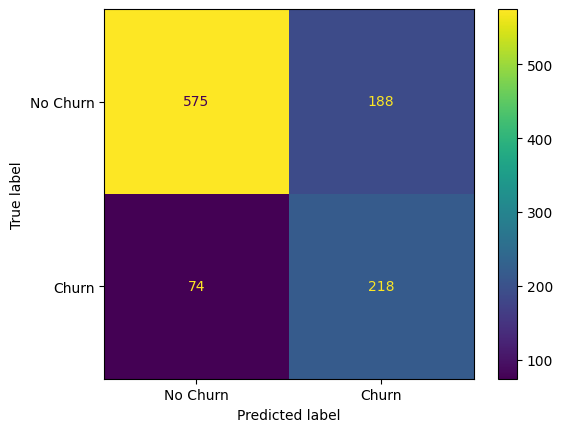

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

y_pred = churn_pipeline.predict(X_test)
y_proba = churn_pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Churn', 'Churn'])
disp.plot()

ROC-AUC Score: 0.8345


<Figure size 1000x600 with 0 Axes>

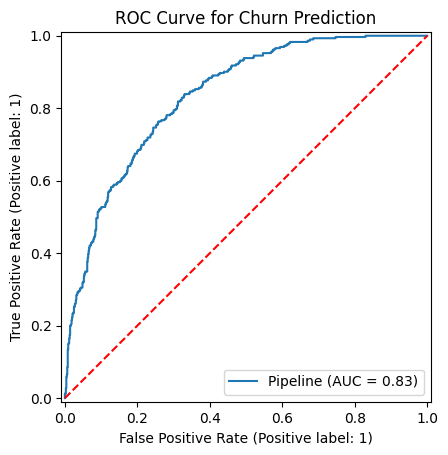

In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

print(f"ROC-AUC Score: {roc_auc_score(y_test, y_proba):.4f}")


plt.figure(figsize=(10, 6))

# Ploting the ROC Curve directly from the pipeline
RocCurveDisplay.from_estimator(churn_pipeline, X_test, y_test)

# Add the diagonal dashed line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

plt.title('ROC Curve for Churn Prediction')
plt.show()

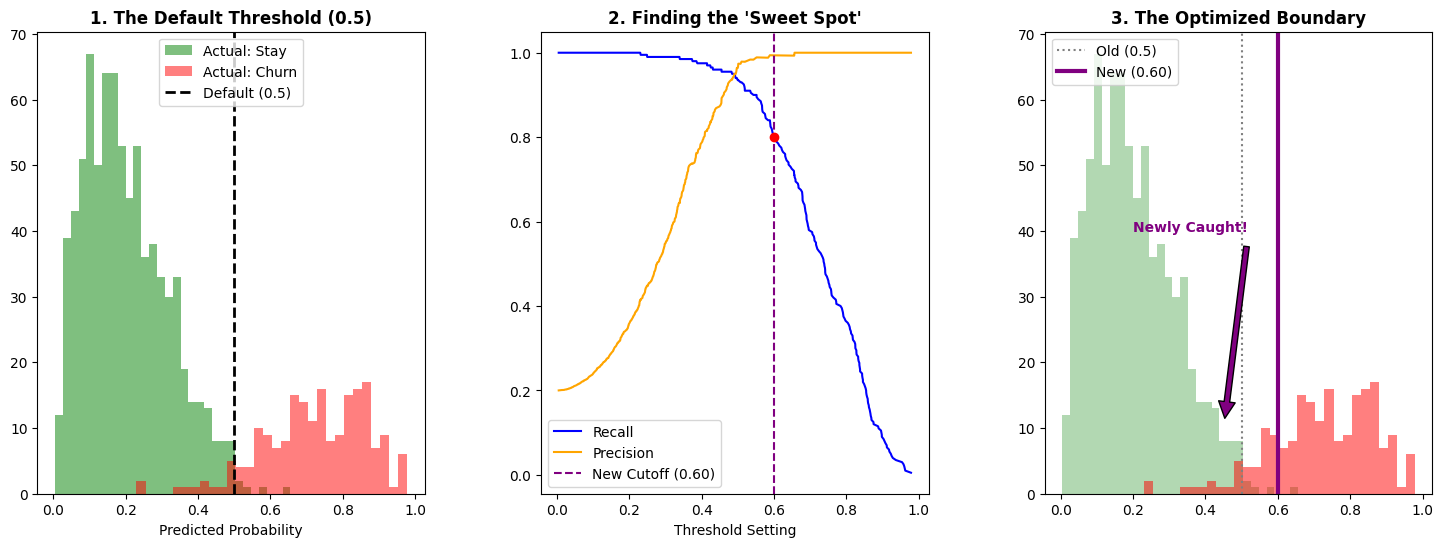

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

#(For Visualization Only)
np.random.seed(42)

# Simulate "Stayers" (Green) - mostly low probability
probs_0 = np.random.beta(2, 8, 800)

# Simulate "Churners" (Red) - dispersed probabilities
probs_1 = np.random.beta(7, 3, 200)

y_true = np.concatenate([np.zeros(800), np.ones(200)])
y_proba = np.concatenate([probs_0, probs_1])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3)

# Plot 1: The Default Problem
axes[0].hist(probs_0, bins=30, color='green', alpha=0.5, label='Actual: Stay')
axes[0].hist(probs_1, bins=30, color='red', alpha=0.5, label='Actual: Churn')
axes[0].axvline(0.5, color='black', linestyle='--', linewidth=2, label='Default (0.5)')
axes[0].set_title("1. The Default Threshold (0.5)", fontsize=12, fontweight='bold')
axes[0].set_xlabel("Predicted Probability")
axes[0].legend(loc='upper center')

# Plot 2: The Tuning Curve
precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
target_recall = 0.80
idx = np.argmin(np.abs(recalls - target_recall))
opt_thresh = thresholds[idx]

axes[1].plot(thresholds, recalls[:-1], color='blue', label='Recall')
axes[1].plot(thresholds, precisions[:-1], color='orange', label='Precision')
axes[1].axvline(opt_thresh, color='purple', linestyle='--', label=f'New Cutoff ({opt_thresh:.2f})')
axes[1].scatter(opt_thresh, recalls[idx], color='red', zorder=5)
axes[1].set_title("2. Finding the 'Sweet Spot'", fontsize=12, fontweight='bold')
axes[1].set_xlabel("Threshold Setting")
axes[1].legend()

# Plot 3: The Solution
axes[2].hist(probs_0, bins=30, color='green', alpha=0.3)
axes[2].hist(probs_1, bins=30, color='red', alpha=0.5)
axes[2].axvline(0.5, color='gray', linestyle=':', label='Old (0.5)')
axes[2].axvline(opt_thresh, color='purple', linewidth=3, label=f'New ({opt_thresh:.2f})')
axes[2].annotate('Newly Caught!', xy=(0.45, 10), xytext=(0.2, 40),
                arrowprops=dict(facecolor='purple', shrink=0.05), color='purple', fontweight='bold')
axes[2].set_title("3. The Optimized Boundary", fontsize=12, fontweight='bold')
axes[2].legend(loc='upper left')

plt.show()

In [15]:
import joblib

# Save the pipeline
joblib.dump(churn_pipeline, 'churn_model.joblib')

print("Model saved successfully as 'churn_model.joblib'")

Model saved successfully as 'churn_model.joblib'
